In [1]:
# import necessary dependencies
import argparse
import os, sys
import pickle
import time
import datetime
from tqdm import tqdm_notebook as tqdm
import copy
import numpy as np
import random

import torchvision
import torchvision.transforms as transforms
# from torchtoolbox.transform import Cutout
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader,Dataset
from record import save_variable, load_variable
from models import ResNet20, CNNCifar, CNNCifar_2
from datasplit import cifar_iid, cifar_noniid, cifar_noniid_simple, cifar_noniid_simple2, cifar_noniid_simple3
from FL import DatasetSplit, LocalUpdate, average_weights
from aggregation import multi_krum, tr_mean
from model_attack import attacking_trimmed_mean, attacking_krum, compute_lambda

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Note: Data poisoning attacks against federated learning (model training) is located at the bottom of this notebook.

Above the model training is the evaluation part of the attacked model.

### ResNet20 &&  SimpleCNN

In [2]:
def conv3x3(inch, outch, stride=1):
    return nn.Conv2d(inch, outch, kernel_size=3,stride=stride, padding=1, bias=False)

class Block(nn.Module):
    def __init__(self, inch, outch, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = conv3x3(inch, outch, stride)
        self.bn1 = nn.BatchNorm2d(outch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(outch, outch)
        self.bn2 = nn.BatchNorm2d(outch)
        self.CONV = None
        if (stride != 1) or (inch != outch):
                self.CONV = nn.Sequential(
                conv3x3(inch, outch, stride=stride),
                nn.BatchNorm2d(outch))        
        
    def forward(self, x):
        temp = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        out = self.bn2(out)
        if self.CONV:
            temp = self.CONV(x)
        out += temp
        out = self.relu(out)
        return out


class ResNet20(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet20, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.layerS1(block, 16, )
        self.layer2 = self.layerS2(block, 32 , 2)
        self.layer3 = self.layerS3(block, 64, 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, 10)

    def layerS1(self, block, out_channels, stride=1):
        layers = []
        layers.append(block(16, 16, stride))
        layers.append(block(16, 16))
        layers.append(block(16, 16))
        return nn.Sequential(*layers)
    
    def layerS2(self, block, out_channels, stride=1):
        layers = []
        layers.append(block(16, 32, stride))       
        layers.append(block(32, 32))
        layers.append(block(32, 32))
        return nn.Sequential(*layers)
    
    def layerS3(self, block, out_channels, stride=1):
        layers = []
        layers.append(block(32, 64, stride))
        
        layers.append(block(64, 64))
        layers.append(block(64, 64))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



class CNNCifar(nn.Module):
    def __init__(self):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
 


### Local Clients

In [3]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        inputs, targets = self.dataset[self.idxs[item]]
        return torch.tensor(inputs), torch.tensor(targets)    
  
    
###################################  Modified  ####################
class LocalUpdate(object):
    def __init__(self, dataset, idxs, Gweight):
        self.trainloader, self.validloader, self.testloader = self.train_val_test(
            dataset, list(idxs))
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Default criterion set to NLL loss function
        self.criterion = nn.CrossEntropyLoss().to(self.device)

    def train_val_test(self, dataset, idxs):
        """
        Returns train, validation and test dataloaders for a given dataset
        and user indexes.
        """
        # split indexes for train, validation, and test (80, 10, 10)
        idxs_train = idxs[:int(0.8*len(idxs))]
        idxs_val = idxs[int(0.8*len(idxs)):int(0.9*len(idxs))]
        idxs_test = idxs[int(0.9*len(idxs)):]

        trainloader = DataLoader(DatasetSplit(dataset, idxs_train),
                                 batch_size=50, shuffle=True)
        validloader = DataLoader(DatasetSplit(dataset, idxs_val),
                                 batch_size=int(len(idxs_val)/10), shuffle=False)
        testloader = DataLoader(DatasetSplit(dataset, idxs_test),
                                batch_size=int(len(idxs_test)/10), shuffle=False)
        return trainloader, validloader, testloader

    def update_weights(self, model, Gweight):
        # Set mode to train model
        model.train()
        if Gweight != None:
            model.load_state_dict(Gweight)
        epoch_loss = []

        # Set optimizer for the local updates
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0001)  ## 0.01

        for iter in range(3):
            batch_loss = []
            for batch_idx, (inputs, targets) in enumerate(self.trainloader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                model.zero_grad()
                outputs = model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                optimizer.step()

                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))

        return model.state_dict(), sum(epoch_loss) / len(epoch_loss)
    
    
    # def update_weights_prox(self, idx, model, Gweight,mu):
    # def update_weights_prox(self, model, Gweight,mu):
    def update_weights_prox(self, model, global_net, Gweight, mu):
        # Set mode to train model
        model.train()
        epoch_loss = []
        if Gweight != None:
            model.load_state_dict(Gweight)
        # w = model.state_dict()
        # if idx in local_weights.keys():
        #     w_old = local_weights[idx]
        # w_avg = model.state_dict()
        # loss_mse = nn.MSELoss().to(self.device)
        global_weight_collector = list(global_net.to(device).parameters())
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001)

        for iter in range(3):
            batch_loss = []
            for batch_idx, (inputs, targets) in enumerate(self.trainloader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                model.zero_grad()
                outputs = model(inputs)
                loss = self.criterion(outputs, targets.long())
                # if idx in local_weights.keys():

                loss2 = 0
                for param_index, param in enumerate(model.parameters()):
                    loss2 += ((mu / 2) * torch.norm((param - global_weight_collector[param_index]))**2)
                loss += loss2
                # w = model.state_dict()

                # for para in w.keys():
                      # loss2 += loss_mse(w_avg[para].float(), w_old[para].float())
                      # loss2 += loss_mse(w_avg[para].float(), Gweights[para].float())
                      # loss2 += ((mu / 2) * torch.norm((w[para] - Gweight[para]))**2)
                # loss2 /= len(local_weights)
                # loss += loss2 * 100
                # loss += loss2 

                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))


        return model.state_dict(), sum(epoch_loss) / len(epoch_loss)
 
    
    def inference(self, model):
        """ Returns the inference accuracy and loss.
        """

        model.eval()
        loss, total, correct = 0.0, 0.0, 0.0

        for batch_idx, (inputs, targets) in enumerate(self.testloader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            # Inference
            outputs = model(inputs)
            batch_loss = self.criterion(outputs, targets.long())
            loss += batch_loss.item()

            # Prediction
            _, pred_targets = torch.max(outputs, 1)
            pred_targets = pred_targets.view(-1)
            correct += torch.sum(torch.eq(pred_targets, targets)).item()
            total += len(targets)

        accuracy = correct/total
        return accuracy, loss
    
def average_weights(w):
    """
    Returns the average of the weights.
    """
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg   

In [4]:
#############################################
# specify preprocessing function
transform_train = transforms.Compose([
    
    transforms.RandomCrop(32,4),
    transforms.RandomHorizontalFlip(),        
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),    
])

transform_poison = transforms.Compose([
    
    transforms.RandomCrop(32,4),
    transforms.RandomHorizontalFlip(),        
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),    
])

transform_val =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),    
])
#############################################

In [5]:
# do NOT change these
# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)

poison_set = CIFAR10(
    root=DATA_ROOT,
    mode='train', 
    download=True, 
    transform=transform_poison)

val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val    # your code
)

val_loader = DataLoader(
    val_set, 
    batch_size= VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified


In [6]:
# specify the device for computation
#############################################
# your code here
device = 'cuda' if torch.cuda.is_available() else 'cpu'
global_net = ResNet20(Block)
# global_net = CNNCifar()
global_net.to(device)
#############################################
criterion = nn.CrossEntropyLoss().to(device)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.69 GiB total capacity; 0 bytes already allocated; 0 bytes free; 0 bytes reserved in total by PyTorch)

## Data Poisoning Attacks - Model Evaluation Part

In [ ]:
def targeted_label_flipping_attack (poison_set, source, target) :
    for i in range(0, len(poison_set.data)) :
        if poison_set.targets[i] == source :
            poison_set.targets[i] = target
    return poison_set

In [ ]:
# Indicate source class and target class.
source_class = 0
target_class = 2

# Implement Targeted Label Flipping Attack.
poisoned_train_set = targeted_label_flipping_attack(poison_set, source_class, target_class)
# Check if Targeted Label Flipping Attack is successful.
for i in range(len(poisoned_train_set.targets)) :
    if poisoned_train_set.targets[i] == source_class :
        print("Attack Failed!")
        break
print("Attack Successful!")

In [11]:
def global_model_accuracy (model, loader, device) :
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    with torch.no_grad() :
        for batch_idx,(data, labels) in enumerate(loader) :
            data = data.to(device); labels = labels.to(device)
            # print(labels.shape)
            # print(len(labels))
            # print(data[0].shape)
            clean_outputs = model(data)
            # clean_loss = F.cross_entropy(clean_outputs, labels.long())
            clean_loss = criterion(clean_outputs, labels.long())
            _, clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
            # print(clean_outputs.shape)
            # print(clean_preds.shape)
    clean_acc = running_correct / running_total
    clean_loss = running_loss / len(loader)
    model.train()
    return clean_acc

In [12]:
def class_recall (model, loader, device, class_X) :
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    with torch.no_grad() :
        for batch_idx,(data, labels) in enumerate(loader) :
            data = data.to(device); labels = labels.to(device)
            clean_outputs = model(data)
            clean_loss = criterion(clean_outputs, labels.long())
            _, clean_preds = clean_outputs.max(1)
            for i in range(0, len(labels)) :
                if labels[i] != class_X :
                    continue
                else :
                    if clean_preds[i] == class_X :
                        running_correct = running_correct + 1
                    else :
                        running_correct = running_correct
                    running_total = running_total + 1
    clean_acc = running_correct / running_total
    return clean_acc

In [13]:
def accuracy_array_list (acc_array) :
    acc_list = []
    for accuracy in acc_array :
        acc_list.append(100 * accuracy)
    return acc_list

In [14]:
x_epochs = np.arange(1, 101)

resnet_standard_acc = []
resnet_malic20_acc = []
resnet_malic40_acc = []
resnet_malic60_acc = []
resnet_malic80_acc = []
resnet_malic100_acc = []

# Load recorded validation results during training back to notebook.
resnet_standard_acc_array = np.array([0.1262, 0.2142, 0.3104, 0.3592, 0.377, 0.403, 0.4254, 0.4462, 0.4708, 0.4676, 
                                      0.4932, 0.5054, 0.5162, 0.5336, 0.54, 0.553, 0.5632, 0.5738, 0.5832, 0.5854, 
                                      0.5986, 0.6002, 0.6126, 0.6176, 0.6242, 0.6324, 0.6362, 0.6436, 0.651, 0.6534, 
                                      0.6564, 0.6654, 0.6738, 0.6688, 0.6802, 0.6874, 0.6892, 0.6912, 0.693, 0.698, 
                                      0.6984, 0.7076, 0.7066, 0.7102, 0.7098, 0.7186, 0.7206, 0.725, 0.7262, 0.7318, 
                                      0.7302, 0.7348, 0.7354, 0.7386, 0.7456, 0.743, 0.7508, 0.7494, 0.7518, 0.756, 
                                      0.7604, 0.7544, 0.7596, 0.7574, 0.7632, 0.7628, 0.77, 0.7636, 0.7712, 0.765, 
                                      0.775, 0.7688, 0.7766, 0.7776, 0.7794, 0.7784, 0.7876, 0.7816, 0.7816, 0.788, 
                                      0.7832, 0.788, 0.7892, 0.7908, 0.7906, 0.7874, 0.7922, 0.7938, 0.7978, 0.7952, 
                                      0.7968, 0.8012, 0.8004, 0.7988, 0.8048, 0.8004, 0.8048, 0.8028, 0.8074, 0.8066])
resnet_malic20_acc_array = np.array([0.1114, 0.1872, 0.2626, 0.3008, 0.3196, 0.3326, 0.357, 0.3738, 0.4118, 0.44, 
                                     0.4516, 0.4742, 0.497, 0.504, 0.517, 0.5342, 0.544, 0.555, 0.5666, 0.5728, 0.5818, 
                                     0.5926, 0.6018, 0.6076, 0.608, 0.6188, 0.6216, 0.6274, 0.6326, 0.6458, 0.6404, 
                                     0.6476, 0.649, 0.6576, 0.6634, 0.6614, 0.6722, 0.6668, 0.6764, 0.676, 0.6842, 
                                     0.686, 0.6904, 0.695, 0.6952, 0.7058, 0.701, 0.7006, 0.715, 0.7162, 0.7082, 0.7168, 
                                     0.722, 0.7172, 0.7262, 0.7266, 0.7226, 0.7328, 0.7382, 0.737, 0.7344, 0.7374, 0.7452, 
                                     0.7464, 0.7426, 0.75, 0.747, 0.7566, 0.7518, 0.759, 0.7584, 0.757, 0.7552, 0.7636, 
                                     0.7632, 0.7632, 0.769, 0.7694, 0.7606, 0.7714, 0.7724, 0.7712, 0.7768, 0.7748, 
                                     0.771, 0.769, 0.7764, 0.7714, 0.7746, 0.7772, 0.777, 0.7828, 0.7794, 0.7802, 0.7674, 
                                     0.7878, 0.78, 0.7888, 0.7778, 0.7894])
resnet_malic40_acc_array = np.array([0.1538, 0.1898, 0.2422, 0.2636, 0.2912, 0.3056, 0.3268, 0.3638, 0.3772, 0.395, 0.4136, 
                                     0.434, 0.4486, 0.4626, 0.4794, 0.4972, 0.5094, 0.518, 0.538, 0.5444, 0.552, 0.5628, 
                                     0.578, 0.5788, 0.5826, 0.5982, 0.6014, 0.6094, 0.6126, 0.6238, 0.6158, 0.632, 0.6282, 
                                     0.6312, 0.6398, 0.644, 0.6606, 0.6428, 0.6582, 0.6546, 0.6606, 0.673, 0.673, 0.6632, 
                                     0.6774, 0.6742, 0.6806, 0.677, 0.6818, 0.6872, 0.6928, 0.6926, 0.6948, 0.7052, 0.7042, 
                                     0.7026, 0.7088, 0.7108, 0.7142, 0.7112, 0.7106, 0.719, 0.729, 0.7136, 0.7302, 0.7238, 
                                     0.7312, 0.7262, 0.7372, 0.7166, 0.7466, 0.705, 0.7584, 0.697, 0.759, 0.7032, 0.7658, 
                                     0.6994, 0.7672, 0.7078, 0.7618, 0.7152, 0.7756, 0.709, 0.7704, 0.7174, 0.7738, 0.7184, 
                                     0.7782, 0.724, 0.7802, 0.7194, 0.7828, 0.7198, 0.7858, 0.7186, 0.7804, 0.724, 0.7856, 
                                     0.7252])
resnet_malic60_acc_array = np.array([0.1084, 0.184, 0.2268, 0.259, 0.2792, 0.3108, 0.337, 0.3528, 0.3894, 0.4148, 0.4306, 
                                     0.4512, 0.4586, 0.4712, 0.4752, 0.4938, 0.4922, 0.5022, 0.5104, 0.5146, 0.52, 0.526, 
                                     0.533, 0.5448, 0.545, 0.5596, 0.5634, 0.5646, 0.5812, 0.5792, 0.5896, 0.5918, 0.5954, 
                                     0.602, 0.6082, 0.6068, 0.6132, 0.6204, 0.6216, 0.6262, 0.6318, 0.6348, 0.6338, 0.646, 
                                     0.6414, 0.638, 0.6478, 0.6446, 0.6526, 0.6514, 0.6648, 0.6578, 0.6642, 0.6642, 0.6714, 
                                     0.6724, 0.669, 0.6682, 0.6786, 0.6752, 0.6766, 0.6846, 0.6824, 0.6886, 0.6844, 0.6994, 
                                     0.6922, 0.6968, 0.6964, 0.7018, 0.6968, 0.7056, 0.698, 0.713, 0.7036, 0.7118, 0.7046, 
                                     0.7156, 0.71, 0.7228, 0.7128, 0.7258, 0.7094, 0.7304, 0.7084, 0.745, 0.716, 0.7508, 
                                     0.714, 0.7622, 0.7142, 0.7598, 0.7166, 0.7638, 0.7234, 0.7658, 0.7206, 0.7738, 0.7226, 
                                     0.7776])
resnet_malic80_acc_array = np.array([0.1442, 0.2022, 0.2294, 0.2624, 0.285, 0.3136, 0.3488, 0.37, 0.3958, 0.4322, 0.4278, 
                                     0.4562, 0.4648, 0.4874, 0.4652, 0.4826, 0.4936, 0.4932, 0.5128, 0.5204, 0.532, 0.5294, 
                                     0.541, 0.5472, 0.5502, 0.5528, 0.562, 0.5666, 0.5754, 0.5706, 0.5728, 0.5826, 0.5846, 
                                     0.5924, 0.5918, 0.5992, 0.6014, 0.6056, 0.612, 0.607, 0.613, 0.6162, 0.6232, 0.6206, 
                                     0.6244, 0.6282, 0.6368, 0.6352, 0.6408, 0.637, 0.6446, 0.6498, 0.6532, 0.6594, 0.6598, 
                                     0.6648, 0.666, 0.6634, 0.668, 0.6682, 0.6708, 0.671, 0.676, 0.6844, 0.6842, 0.6848, 
                                     0.6896, 0.6908, 0.6882, 0.6916, 0.6938, 0.6908, 0.692, 0.6968, 0.6944, 0.702, 0.6982, 
                                     0.7048, 0.7066, 0.704, 0.7074, 0.7094, 0.7068, 0.7098, 0.7166, 0.7146, 0.7104, 0.7184, 
                                     0.7154, 0.7134, 0.7162, 0.7188, 0.7208, 0.7204, 0.7202, 0.7226, 0.7218, 0.7272, 0.7274, 
                                     0.7278])
resnet_malic100_acc_array = np.array([0.1216, 0.1888, 0.2284, 0.254, 0.2912, 0.326, 0.3544, 0.369, 0.3998, 0.4172, 0.4328, 
                                      0.4524, 0.4556, 0.4748, 0.4818, 0.4852, 0.5012, 0.5028, 0.513, 0.518, 0.5238, 0.5278, 
                                      0.539, 0.5448, 0.5442, 0.5494, 0.5586, 0.5646, 0.5732, 0.5756, 0.577, 0.5804, 0.5788, 
                                      0.5846, 0.5904, 0.5938, 0.5952, 0.5974, 0.5998, 0.6058, 0.6152, 0.614, 0.6178, 0.6156, 
                                      0.622, 0.6268, 0.6266, 0.6274, 0.6274, 0.6348, 0.6348, 0.6434, 0.6328, 0.6438, 0.6474, 
                                      0.645, 0.6468, 0.6566, 0.6484, 0.6536, 0.654, 0.6526, 0.6624, 0.6646, 0.6648, 0.6662, 
                                      0.6678, 0.673, 0.672, 0.6778, 0.6766, 0.6832, 0.6714, 0.6816, 0.6844, 0.682, 0.6824, 
                                      0.6846, 0.6872, 0.6898, 0.6904, 0.692, 0.6946, 0.6926, 0.6986, 0.695, 0.6956, 0.6978, 
                                      0.7006, 0.6992, 0.7076, 0.7052, 0.7052, 0.7086, 0.7092, 0.707, 0.7132, 0.7062, 0.711, 
                                      0.7138])

# print(len(resnet_standard_acc_array))
# print(len(resnet_malic20_acc_array))
# print(len(resnet_malic40_acc_array))
# print(len(resnet_malic60_acc_array))
# print(len(resnet_malic80_acc_array))
# print(len(resnet_malic100_acc_array))

resnet_standard_acc = accuracy_array_list(resnet_standard_acc_array)
resnet_malic20_acc = accuracy_array_list(resnet_malic20_acc_array)
resnet_malic40_acc = accuracy_array_list(resnet_malic40_acc_array)
resnet_malic60_acc = accuracy_array_list(resnet_malic60_acc_array)
resnet_malic80_acc = accuracy_array_list(resnet_malic80_acc_array)
resnet_malic100_acc = accuracy_array_list(resnet_malic100_acc_array)

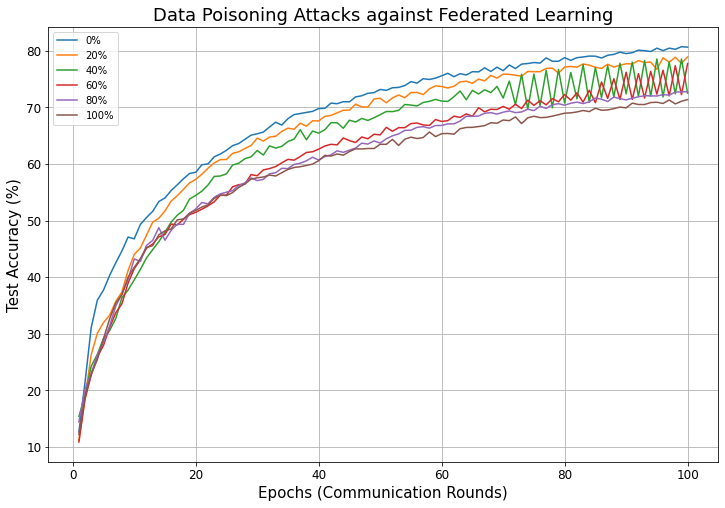

In [59]:
figure, axis = plt.subplots()

axis.plot(x_epochs, resnet_standard_acc, label = "0%")
axis.plot(x_epochs, resnet_malic20_acc, label = "20%")
axis.plot(x_epochs, resnet_malic40_acc, label = "40%")
axis.plot(x_epochs, resnet_malic60_acc, label = "60%")
axis.plot(x_epochs, resnet_malic80_acc, label = "80%")
axis.plot(x_epochs, resnet_malic100_acc, label = "100%")

axis.set_xlabel("Epochs (Communication Rounds)", fontsize = 15) 
axis.set_ylabel("Test Accuracy (%)", fontsize = 15)
axis.set_title("Data Poisoning Attacks against Federated Learning", fontsize = 18)

axis.grid()
figure.set_size_inches(12, 8)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

In [16]:
resnet_standard = ResNet20(Block).to(device)
resnet_standard.load_state_dict(torch.load("ResNet20_E100_Clients100_Standard.pt"))
resnet_20malic = ResNet20(Block).to(device)
resnet_20malic.load_state_dict(torch.load("ResNet20_E100_Clients100_Malicious20_Source0_Target2.pt"))
resnet_40malic = ResNet20(Block).to(device)
resnet_40malic.load_state_dict(torch.load("ResNet20_E100_Clients100_Malicious40_Source0_Target2.pt"))
resnet_60malic = ResNet20(Block).to(device)
resnet_60malic.load_state_dict(torch.load("ResNet20_E100_Clients100_Malicious60_Source0_Target2.pt"))
resnet_80malic = ResNet20(Block).to(device)
resnet_80malic.load_state_dict(torch.load("ResNet20_E100_Clients100_Malicious80_Source0_Target2.pt"))
resnet_100malic = ResNet20(Block).to(device)
resnet_100malic.load_state_dict(torch.load("ResNet20_E100_Clients100_Malicious100_Source0_Target2.pt"))

<All keys matched successfully>

In [17]:
malicious_percentage = np.array([0, 20, 40, 60, 80, 100])

source_recalls = []
target_recalls = []

source_recalls.append(100 * class_recall(resnet_standard, val_loader, device, class_X = source_class))
source_recalls.append(100 * class_recall(resnet_20malic, val_loader, device, class_X = source_class))
source_recalls.append(100 * class_recall(resnet_40malic, val_loader, device, class_X = source_class))
source_recalls.append(100 * class_recall(resnet_60malic, val_loader, device, class_X = source_class))
source_recalls.append(100 * class_recall(resnet_80malic, val_loader, device, class_X = source_class))
source_recalls.append(100 * class_recall(resnet_100malic, val_loader, device, class_X = source_class))
target_recalls.append(100 * class_recall(resnet_standard, val_loader, device, class_X = target_class))
target_recalls.append(100 * class_recall(resnet_20malic, val_loader, device, class_X = target_class))
target_recalls.append(100 * class_recall(resnet_40malic, val_loader, device, class_X = target_class))
target_recalls.append(100 * class_recall(resnet_60malic, val_loader, device, class_X = target_class))
target_recalls.append(100 * class_recall(resnet_80malic, val_loader, device, class_X = target_class))
target_recalls.append(100 * class_recall(resnet_100malic, val_loader, device, class_X = target_class))

In [22]:
def average_classes_recall (model, val_loader, device, source_class, target_class) :
    class_labels = np.arange(10)
    total_acc = 0
    for label in class_labels :
        if label == source_class or label == target_class :
            continue
        else :
            total_acc = total_acc + class_recall(model, val_loader, device, label)
    average_recall = total_acc / float(8)
    return average_recall

In [23]:
other_avg_recall = []
other_avg_recall.append(100 * average_classes_recall(resnet_standard, val_loader, device, source_class, target_class))
other_avg_recall.append(100 * average_classes_recall(resnet_20malic, val_loader, device, source_class, target_class))
other_avg_recall.append(100 * average_classes_recall(resnet_40malic, val_loader, device, source_class, target_class))
other_avg_recall.append(100 * average_classes_recall(resnet_60malic, val_loader, device, source_class, target_class))
other_avg_recall.append(100 * average_classes_recall(resnet_80malic, val_loader, device, source_class, target_class))
other_avg_recall.append(100 * average_classes_recall(resnet_100malic, val_loader, device, source_class, target_class))

In [24]:
print(source_recalls)
print(target_recalls)
print(other_avg_recall)

[92.10526315789474, 77.32793522267207, 74.89878542510121, 58.2995951417004, 0.0, 0.0]
[84.90945674044266, 82.49496981891348, 84.50704225352112, 81.89134808853119, 82.897384305835, 82.897384305835]
[78.73855709307637, 78.60047656906029, 78.15548793686625, 79.53324554324874, 80.40732298617208, 78.68988386756965]


In [25]:
def float_format (accuracies) :
    acc_format = ["%.4f" % element for element in accuracies]
    for i in range(len(accuracies)) :
        acc_format[i] = float(acc_format[i])
    return acc_format

source_recalls = float_format(source_recalls)
target_recalls = float_format(target_recalls)
other_avg_recalls = float_format(other_avg_recall)
print(source_recalls)
print(target_recalls)
print(other_avg_recalls)
# Printed results are shown below
# [92.1053, 77.3279, 74.8988, 58.2996, 0.0, 0.0]
# [84.9095, 82.495, 84.507, 81.8913, 82.8974, 82.8974]
# [78.7386, 78.6005, 78.1555, 79.5332, 80.4073, 78.6899]

[92.1053, 77.3279, 74.8988, 58.2996, 0.0, 0.0]
[84.9095, 82.495, 84.507, 81.8913, 82.8974, 82.8974]
[78.7386, 78.6005, 78.1555, 79.5332, 80.4073, 78.6899]


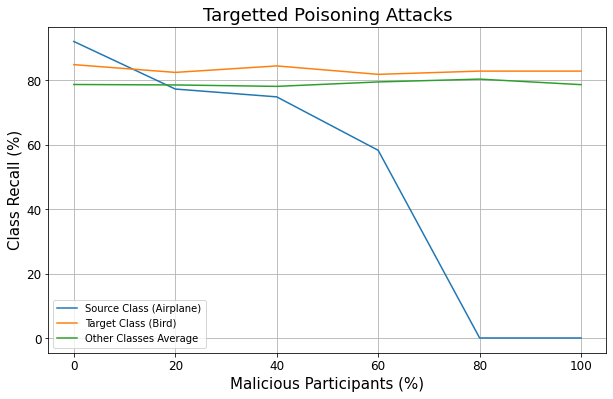

In [60]:
figure, axis = plt.subplots()

axis.plot(malicious_percentage, source_recalls, label = "Source Class (Airplane)")
axis.plot(malicious_percentage, target_recalls, label = "Target Class (Bird)")
axis.plot(malicious_percentage, other_avg_recalls, label = "Other Classes Average")

# axis.set(xlabel = "Malicious Participants (%)", 
#          ylabel = "Class Recall (%)", 
#          title = "Targetted Poisoning Attacks")

axis.set_title("Targetted Poisoning Attacks", fontsize = 18)
axis.set_xlabel("Malicious Participants (%)", fontsize = 15)
axis.set_ylabel("Class Recall (%)", fontsize = 15)

axis.grid()

figure.set_size_inches(10, 6)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

In [33]:
source_recall_standard = []
source_recall_first_epochs = []
source_recall_last_epochs = []

array_standard = np.array([0.0, 0.168, 0.3462, 0.3887, 0.3623, 0.413, 0.496, 0.5283, 0.6073, 0.6194, 0.664, 0.664, 
                           0.6923, 0.7429, 0.7692, 0.7874, 0.7814, 0.7551, 0.8036, 0.7976, 0.8036, 0.8198, 0.83, 0.8057, 
                           0.8259, 0.8462, 0.8239, 0.8016, 0.8462, 0.8704, 0.8502, 0.8259, 0.8441, 0.836, 0.8725, 0.8441, 
                           0.8381, 0.8644, 0.9049, 0.8482, 0.9028, 0.8988, 0.8765, 0.8543, 0.8968, 0.8441, 0.8887, 0.8684, 
                           0.8603, 0.9089, 0.8603, 0.8765, 0.8704, 0.8846, 0.8684, 0.9028, 0.8644, 0.8745, 0.8866, 0.9049, 
                           0.8887, 0.8704, 0.8725, 0.8927, 0.8785, 0.8603, 0.9089, 0.8765, 0.8806, 0.8765, 0.9008, 0.8887, 
                           0.8846, 0.8725, 0.8684, 0.917, 0.8806, 0.8806, 0.8704, 0.9008, 0.8947, 0.8968, 0.8543, 0.8887, 
                           0.8846, 0.9028, 0.8826, 0.919, 0.8947, 0.9049, 0.913, 0.9008, 0.8947, 0.9211, 0.8866, 0.8765, 
                           0.9028, 0.8927, 0.9109, 0.9008])
array_first_epochs = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0121, 0.0182, 0.0324, 0.0607, 0.0587, 0.081, 0.1053, 
                               0.1235, 0.1538, 0.1761, 0.1964, 0.2186, 0.251, 0.2206, 0.3158, 0.2976, 0.2733, 0.3644, 0.3543, 
                               0.4028, 0.3725, 0.3583, 0.4271, 0.4089, 0.413, 0.4474, 0.4271, 0.4312, 0.4332, 0.4231, 0.4372,
                               0.4332, 0.4656, 0.4798, 0.4636, 0.4514, 0.4798, 0.5567, 0.4818, 0.5344, 0.5628, 0.4777, 0.4858, 
                               0.7834, 0.8765, 0.8583, 0.8644, 0.8603, 0.8745, 0.8482, 0.8259, 0.8927, 0.836, 0.8664, 0.8927,
                               0.8765, 0.8684, 0.915, 0.9109, 0.8603, 0.8927, 0.8765, 0.8725, 0.9049, 0.8887, 0.8907, 0.8765, 
                               0.8927, 0.8866, 0.9049, 0.8846, 0.8927, 0.9028, 0.8947, 0.917, 0.8988, 0.913, 0.9028, 0.8806, 
                               0.8887, 0.919, 0.9089, 0.9008, 0.9008, 0.9028, 0.9049, 0.9049, 0.913, 0.9069, 0.9251, 0.919, 
                               0.8866, 0.9028])
array_last_epochs = np.array([0.0, 0.0162, 0.1215, 0.1923, 0.3178, 0.3219, 0.3482, 0.4555, 0.5, 0.5364, 0.504, 0.5789, 
                              0.6377, 0.6538, 0.7024, 0.6984, 0.747, 0.7591, 0.7328, 0.7814, 0.8381, 0.7834, 0.7794, 0.836, 
                              0.7652, 0.8239, 0.83, 0.8279, 0.8421, 0.8158, 0.8117, 0.8219, 0.8664, 0.8704, 0.8725, 0.8623, 
                              0.8563, 0.8725, 0.8441, 0.8704, 0.8785, 0.8644, 0.8644, 0.8664, 0.9231, 0.8826, 0.8785, 0.8401, 
                              0.8745, 0.8482, 0.0061, 0.7227, 0.3158, 0.6397, 0.4717, 0.6235, 0.4838, 0.5324, 0.5263, 0.5081, 
                              0.5142, 0.5891, 0.4879, 0.5405, 0.5283, 0.5789, 0.5506, 0.6356, 0.5526, 0.6134, 0.5567, 0.5911, 
                              0.5324, 0.5709, 0.5729, 0.6032, 0.5688, 0.6154, 0.4717, 0.6073, 0.5506, 0.6619, 0.4899, 0.666, 
                              0.4049, 0.6822, 0.3644, 0.6538, 0.3158, 0.6903, 0.2105, 0.6802, 0.1903, 0.6943, 0.085, 0.6842, 
                              0.1032, 0.7085, 0.1012, 0.7085])
# print(len(array_standard))
# print(len(array_first_epochs))
# print(len(array_last_epochs))
source_recall_standard = accuracy_array_list(array_standard)
source_recall_first_epochs = accuracy_array_list(array_first_epochs)
source_recall_last_epochs = accuracy_array_list(array_last_epochs)

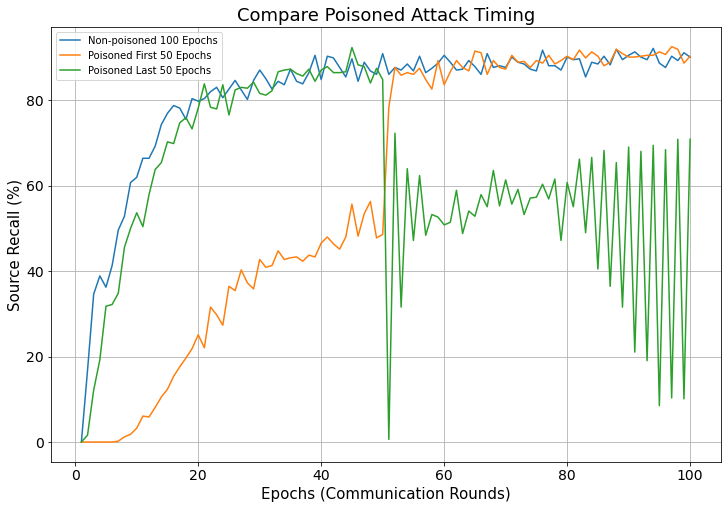

In [61]:
x_epochs = np.arange(1, 101)

figure, axis = plt.subplots()

axis.plot(x_epochs, source_recall_standard, label = "Non-poisoned 100 Epochs")
axis.plot(x_epochs, source_recall_first_epochs, label = "Poisoned First 50 Epochs")
axis.plot(x_epochs, source_recall_last_epochs, label = "Poisoned Last 50 Epochs")

# axis.set(xlabel = "Epochs (Communication Rounds)", 
#          ylabel = "Source Recall (%)",  
#          title = "Compare Poisoned Attack Timing")

axis.set_title("Compare Poisoned Attack Timing", fontsize = 18)
axis.set_xlabel("Epochs (Communication Rounds)", fontsize = 15)
axis.set_ylabel("Source Recall (%)", fontsize = 15)

axis.grid()

figure.set_size_inches(12, 8)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.legend()
plt.show()

## Data Poisoning Attacks against Federated Learning - Model Training Part

In [ ]:
# some hyperparameters
# total number of training epochs
# EPOCHS = 100
EPOCHS = 100

# malicious = 0.1
# malicious = 0.2
# malicious = 0.3
malicious = 0.4
# malicious = 0.5
# malicious = 0.6
# malicious = 0.7
# malicious = 0.8
# malicious = 0.9
# malicious = 1.0

# C = 0.1
# C = 0.2
# C = 0.3
# C = 0.4
# C = 0.5
# C = 0.6
# C = 0.7
# C = 0.8
# C = 0.9
C = 1.0

K = 100

# model_checkpoint = "CNNCifar_E100_Clients90_Standard.pt"
# model_checkpoint = "CNNCifar_E100_Clients100_Standard.pt"

# model_checkpoint = "ResNet20_E100_Clients100_Standard.pt"

# model_checkpoint = "ResNet20_E100_Clients100_Malicious10_Source0_Target2.pt"
# model_checkpoint = "ResNet20_E100_Clients100_Malicious20_Source0_Target2.pt"
# model_checkpoint = "ResNet20_E100_Clients100_Malicious30_Source0_Target2.pt"
# model_checkpoint = "ResNet20_E100_Clients100_Malicious40_Source0_Target2.pt"
# model_checkpoint = "ResNet20_E100_Clients100_Malicious60_Source0_Target2.pt"
# model_checkpoint = "ResNet20_E100_Clients100_Malicious80_Source0_Target2.pt"
# model_checkpoint = "ResNet20_E100_Clients100_Malicious100_Source0_Target2.pt"

# model_checkpoint = "ResNet20_AttackTiming_Standard.pt"
# model_checkpoint = "ResNet20_AttackTiming_Malicious60_1to50Epochs.pt" # Not Good
# model_checkpoint = "ResNet20_AttackTiming_Malicious40_1to50Epochs.pt"
model_checkpoint = "ResNet20_AttackTiming_Malicious40_51to100Epochs.pt"

###########   Use different type of Data :    IID, NON-IID (1 CLASS/ 2 CLASS/ 3 CLASS)  ##########
#user_groups = cifar_iid(train_set, 10)
user_groups = cifar_iid(train_set, 100)
#user_groups = cifar_noniid(train_set, K)
#user_groups = cifar_noniid_simple2(train_set, K)
######################################################################

# start the training/validation process
best_val_acc = 0
current_learning_rate = 0.01
print("==> Training starts!")
print("="*50)

train_loss, train_accuracy = [], []
Validation_acc_global = []
Validation_source_recall_global = []

##############  Initialize all the clients model, for later randomly pick up  #################
# client_models = {i: CNNCifar().to(device) for i in range(K)}
client_models = {i: ResNet20(Block).to(device) for i in range(K)}

##############  Training begins   ##############
for epoch in range(0, EPOCHS):
    # handle the learning rate scheduler.
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')
    #######################
    # switch to train mode
    global_net.train()
    print("Epoch %d:" %(epoch+1))
     
    ######## m is the number of clients, C is the ration and K is the total number of candidate.
    m = int(max(C*K,1))
    
    malicious_clients = int(malicious * m)
    malicious_participants = np.arange(malicious_clients)
    
    ######## randomly pick m clients from K candidate
#     List111 = []
#     [List111.append(i) for i in range (K)]
#     random.shuffle(List111)
#     List1 = []
#     for i in range(m):
#         List1.append(List111[i])
    ##################################################
    List1=[]
    [List1.append(i) for i in range(m)]
    random.shuffle(List1)
    ####################### 
    """
    分好了client的id之后，对应clients模型的调用
    调用模型的时候，1.初始化，2.对应数据，按照clients的数量分成n份，3.每个数据训练后得到W和loss
    使用state_dict来获得模型更新的weight，输出
    把每个client的weight求和并取平均，作为server的新weight
    
    先做IID，再做non-IID
    
    """
    global_weights = global_net.state_dict()
    
    # Standard Federated Learning
    # local_model = {i: LocalUpdate(dataset=train_set,idxs=user_groups[i],Gweight = global_weights) for i in List1}
    
    # Implement Targeted Label Flipping Attack
    # Inject poisoned data into local clients
    local_model = dict()
    for random_index in List1 :
        if random_index in malicious_participants :
            # if (epoch + 1) <= 50 :   # Attack during Epochs 1 - 50
            if (epoch + 1) > 50 :    # Attack during Epochs 51 - 100
                local_model[random_index] = LocalUpdate(dataset = poisoned_train_set, 
                                                        idxs = user_groups[random_index], 
                                                        Gweight = global_weights)
            else :
                local_model[random_index] = LocalUpdate(dataset = train_set, 
                                                        idxs = user_groups[random_index], 
                                                        Gweight = global_weights)
        else :
            local_model[random_index] = LocalUpdate(dataset = train_set, 
                                                    idxs = user_groups[random_index], 
                                                    Gweight = global_weights)
    
    """
    这里初始化了Localmodel后，对应的local_model的data && local_model的model就可以采用对应的attack
    比如 local_model.trainloader  &  直接修改client_models[idx]并且传入后续权重更新过程
    之后要实现随机attack，也就是指定几个0-99的
    """   
    for idx in List1 :
        w, loss = local_model[idx].update_weights(model = client_models[idx], Gweight = global_weights)
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

        # update global weights
    global_weights = average_weights(local_weights)

        # update global weights
    global_net.load_state_dict(global_weights)
    
    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    
#     global_net.eval()
#     list_acc, list_loss = [], []
    
#     ######### check what is wrong #########
#     for c in range(K):
#         local_model = LocalUpdate(dataset=train_set,idxs=user_groups[idx],Gweight = None)
#         acc, loss = local_model.inference(model=global_net)
#         list_acc.append(acc)
#         list_loss.append(loss)
#         train_accuracy.append(sum(list_acc)/len(list_acc))
#     print(f' \nAvg Training Stats after {i+1} global rounds:')
#     print(f'Training Loss : {np.mean(np.array(train_loss))}')
#     print('Train Accuracy: {:.4f}% \n'.format(100*train_accuracy[-1]))

    # Validate on the validation dataset
    #######################
    # switch to eval mode
    global_net.eval()  
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            #targets = torch.Tensor(targets).long()
            targets = targets.to(device)
            # compute the output and loss
            outputs = global_net(inputs)        
            loss = criterion(outputs, targets.long())
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            ##############
            total_examples+=targets.shape[0]
            correct_examples+=correct.item()
            val_loss+=loss
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, 100*avg_acc))
    Validation_acc_global.append(avg_acc)
    
    # Record source class recall for each communication round (epoch)
    epoch_source_recall = class_recall(global_net, val_loader, device, source_class)
    Validation_source_recall_global.append(epoch_source_recall)
    print("Source Recall: %.4f" % (100 * epoch_source_recall))
    
    # filename = save_variable(Validation_acc_global,'accuracy4.txt')
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        print("Saving ...")
        torch.save(global_net.state_dict(), model_checkpoint)
        
    print('')
    
print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

In [ ]:
# print(Validation_acc_global)
# print(Validation_source_recall_global)
Validation_source_formatted = ["%.4f" % element for element in Validation_source_recall_global]
for i in range(len(Validation_source_formatted)) :
    Validation_source_formatted[i] = float(Validation_source_formatted[i])
print(Validation_source_formatted)